In [ ]:
!pip install diffusers accelerate transformers datasets

In [1]:
import os, sys, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt


if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append('..')
    os.chdir('..')

import dataset

# Demo: extracting images from SWFD_semicircle_RawBP.h5

In [10]:
import torch

oadat_dir = '/mydata/dlbirhoui/firat/OADAT' ## switch with path to OADAT parent directory.
fname_SWFDsc = os.path.join(oadat_dir, 'SWFD_semicircle_RawBP.h5')

with h5py.File(fname_SWFDsc, 'r') as f:
    print(f.keys())
    pIDs = f['patientID'][()]
    unique_pIDs = np.unique(pIDs)
    pID_counts = {pID: np.sum(pIDs == pID) for pID in unique_pIDs}
    print(f'Unique patient IDs (and counts): {pID_counts}')
    num_images = f['sc_BP'].shape[0]
    print("number of images in sc_BP: ", num_images)

key = 'sc_BP' #semi-circle back-projection
prng = np.random.RandomState(42)
scaleclip_fn = lambda x: torch.from_numpy(np.clip(x/np.max(x), a_min=-0.2, a_max=None)) ## a standard scaling function for the optoacoustic iamge data.
dataset_obj = dataset.Dataset(fname_h5=fname_SWFDsc, key=key, transforms=scaleclip_fn, inds=None, shuffle=True, prng=prng)

<KeysViewHDF5 ['patientID', 'sc,lv128_BP', 'sc,lv128_raw', 'sc,ss128_BP', 'sc,ss128_raw', 'sc,ss32_BP', 'sc,ss32_raw', 'sc,ss64_BP', 'sc,ss64_raw', 'sc_BP', 'sc_raw', 'side', 'skin_type', 'sliceID']>
Unique patient IDs (and counts): {1: 2802, 2: 2802, 3: 2802, 4: 2802, 5: 2802, 6: 2802, 7: 2802, 8: 2802, 9: 2802, 10: 2802, 11: 2802, 12: 2802, 13: 2802, 14: 2802}
number of images in sc_BP:  39228


# Visualize images from SCD_RawBP.h5

<KeysViewHDF5 ['ground_truth', 'labels', 'linear_BP', 'linear_raw', 'ms_BP', 'ms_raw', 'sliceID', 'vc,lv128_BP', 'vc,lv128_raw', 'vc,ss128_BP', 'vc,ss128_raw', 'vc,ss32_BP', 'vc,ss32_raw', 'vc,ss64_BP', 'vc,ss64_raw', 'vc_BP', 'vc_raw']>
number of images in ground_truth:  20000
torch.Size([256, 256])


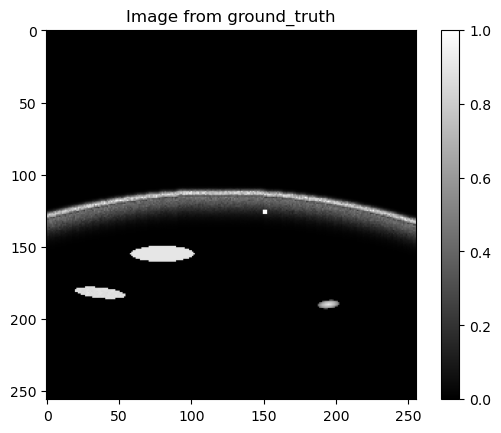

number of images in labels:  20000
torch.Size([256, 256])


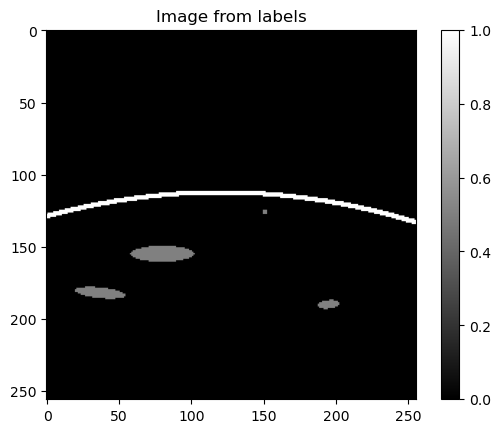

number of images in linear_BP:  20000
torch.Size([256, 256])


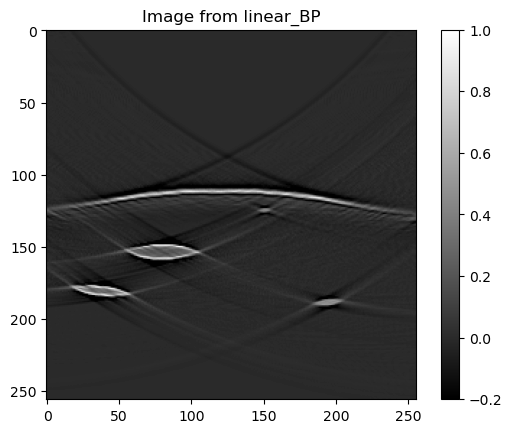

number of images in ms_BP:  20000
torch.Size([256, 256])


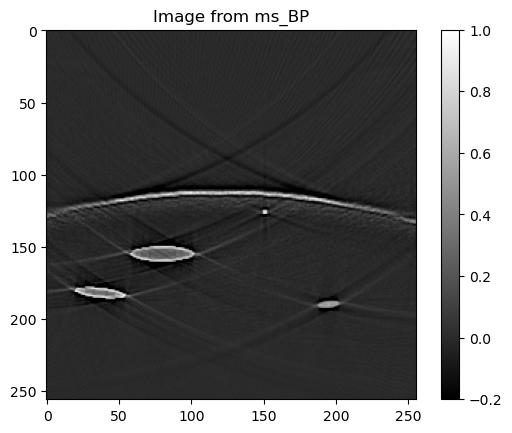

number of images in vc,lv128_BP:  20000
torch.Size([256, 256])


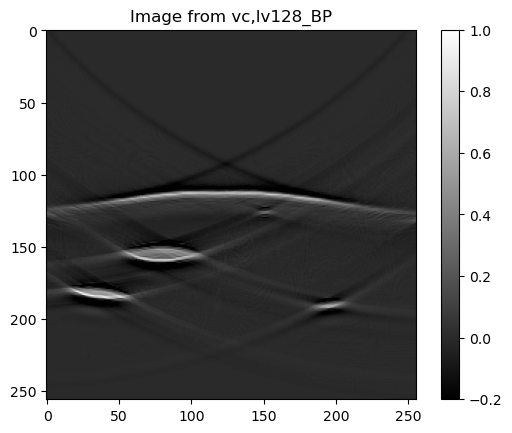

number of images in vc,ss128_BP:  20000
torch.Size([256, 256])


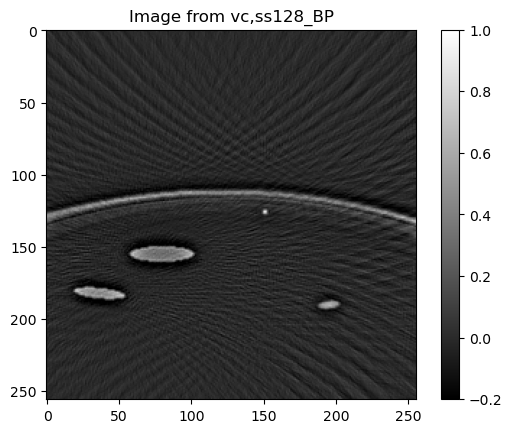

number of images in vc,ss32_BP:  20000
torch.Size([256, 256])


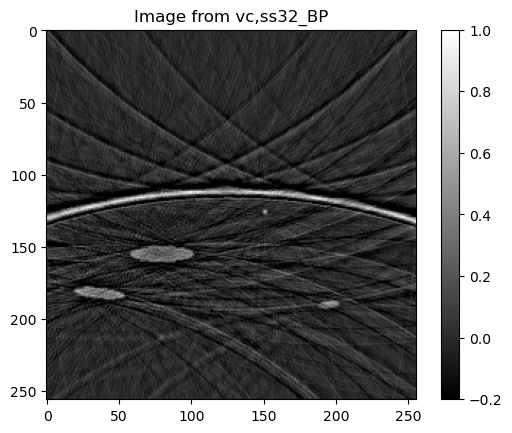

number of images in vc,ss64_BP:  20000
torch.Size([256, 256])


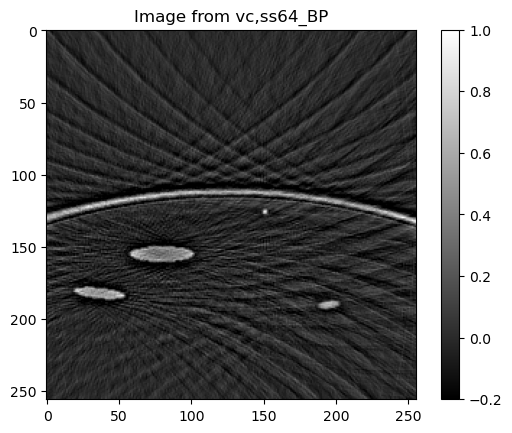

number of images in vc_BP:  20000
torch.Size([256, 256])


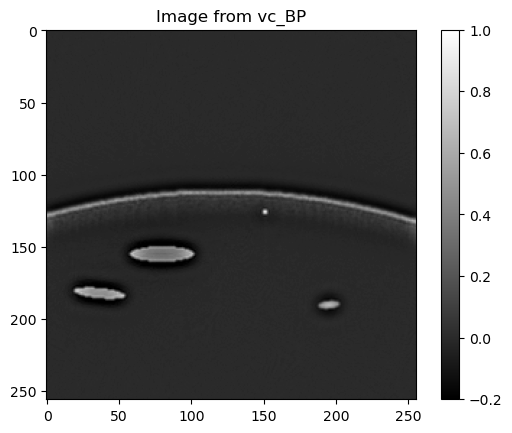

In [17]:
import torch

oadat_dir = '/mydata/dlbirhoui/firat/OADAT' ## switch with path to OADAT parent directory.
fname_SCD = os.path.join(oadat_dir, 'SCD_RawBP.h5')

with h5py.File(fname_SCD, 'r') as f:
    print(f.keys())
    # exclude the keys with 'raw' and 'sliceID' in their names
    keys = [key for key in f.keys() if 'raw' not in key and 'sliceID' not in key]
    for key in keys:
        num_images = f[key].shape[0]
        print(f"number of images in {key}: ", num_images)
        dataset_obj = dataset.Dataset(fname_h5=fname_SCD, key=key, transforms=scaleclip_fn, inds=[0], shuffle=True, prng=prng)
        x = dataset_obj[0]
        x = x[0] ## drop the channel axis
        print(x.shape)
        plt.imshow(x, cmap='gray')
        plt.title(f'Image from {key}')
        plt.colorbar()
        plt.show()


# compare keys in SCD_RawBP-mini.h5 and SCD_RawBP.h5

In [8]:
# compare the keys of the two datasets: SCD_RawBP-mini.h5 and SCD_RawBP.h5
fname_SCD = os.path.join(oadat_dir, 'SCD_RawBP.h5')
fname_SCD_mini = os.path.join(oadat_dir, 'SCD_RawBP-mini.h5')
with h5py.File(fname_SCD, 'r') as f:
  keys_SCD_set = set(f.keys())
  print("the number of keys in SCD_RawBP.h5 is: ", len(keys_SCD_set))
with h5py.File(fname_SCD_mini, 'r') as f:
  keys_SCD_mini_set = set(f.keys())
  print("the number of keys in SCD_RawBP-mini.h5 is: ", len(keys_SCD_mini_set))

is_equal = keys_SCD_set == keys_SCD_mini_set
print("Are the keys of the two datasets equal? ", is_equal)

# show the differences
diff = keys_SCD_set.symmetric_difference(keys_SCD_mini_set)
print("The differences between the keys of the two datasets are: ", diff)


the number of keys in SCD_RawBP.h5 is:  17
the number of keys in SCD_RawBP-mini.h5 is:  23
Are the keys of the two datasets equal?  False
The differences between the keys of the two datasets are:  {'ms,lv128_BP', 'ms,ss128_BP', 'ms,ss64_raw', 'ms,ss32_raw', 'ms,ss64_BP', 'ms,ss32_BP'}


# Creating train and test indices files

In [4]:
import torch

oadat_dir = '/mydata/dlbirhoui/firat/OADAT' ## switch with path to OADAT parent directory.
fname_SWFDsc = os.path.join(oadat_dir, 'SWFD_semicircle_RawBP.h5')

with h5py.File(fname_SWFDsc, 'r') as f:
    # print(f.keys())
    pIDs = f['patientID'][()]
    unique_pIDs = np.unique(pIDs)
    num_patient = len(unique_pIDs)
    train_indices = np.where(pIDs != num_patient)[0]
    test_indices = np.where(pIDs == num_patient)[0]
    print("len train: ", len(train_indices))
    print("len test: ", len(test_indices))
output_train_file = os.path.join('/mydata/dlbirhoui/chia/oadat-ldm/', 'train_sc_BP_indices.npy')
output_test_file = os.path.join('/mydata/dlbirhoui/chia/oadat-ldm/', 'test_sc_BP_indices.npy')

np.save(output_train_file, train_indices)
np.save(output_test_file, test_indices)

len train:  36426
len test:  2802


In [5]:
train_indices = np.load('/mydata/dlbirhoui/chia/oadat-ldm/train_sc_BP_indices.npy')
test_indices = np.load('/mydata/dlbirhoui/chia/oadat-ldm/test_sc_BP_indices.npy')
print("len train: ", len(train_indices))
print("len test: ", len(test_indices))

len train:  36426
len test:  2802


torch.Size([256, 256])


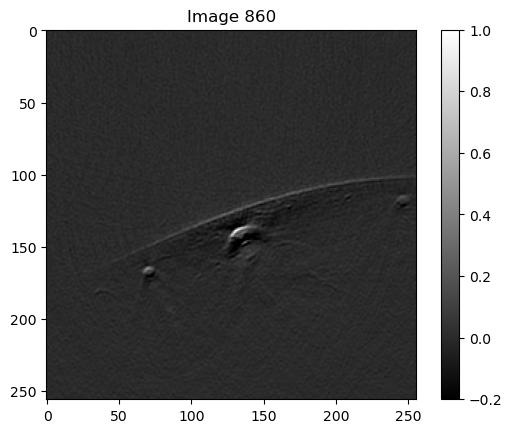

In [8]:
i = prng.randint(0, num_images)
x = dataset_obj[i]
x = x[0] ## drop the channel axis
print(x.shape)
plt.imshow(x, cmap='gray')
plt.title(f'Image {i}')
plt.colorbar()
plt.show()


# Example of ddpm

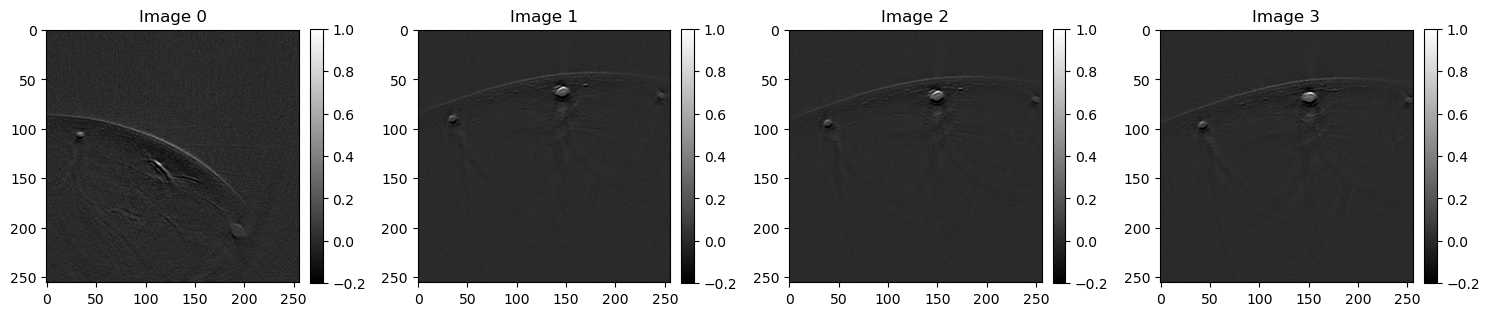

In [7]:
import matplotlib.pyplot as plt

num_images_to_display = 4
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    x = dataset_obj[i]  
    x = x[0]
    im = axs[i].imshow(x, cmap='gray')
    axs[i].set_title(f'Image {i}')
    plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [9]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-oadat-swfd-sc"  # the model name locally and on the HF Hub
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [11]:
import torch

train_dataloader = torch.utils.data.DataLoader(
    dataset_obj, batch_size=config.train_batch_size, shuffle=True
)

In [14]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(
        128,
        128,
        256,
        256,
        512,
        512,
    ),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [15]:
sample_image = dataset_obj[0][0].unsqueeze(0).unsqueeze(0)
print("Input shape:", sample_image.shape)

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


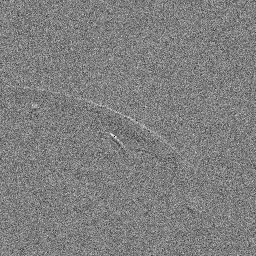

In [33]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.squeeze(0).squeeze(0)+ 1.0) * 127.5).type(torch.uint8).numpy())


In [34]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [36]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [37]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device="cpu").manual_seed(
            config.seed
        ),  # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [40]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path


def train_loop(
    config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler
):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(
            total=len(train_dataloader), disable=not accelerator.is_local_main_process
        )
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bs,),
                device=clean_images.device,
                dtype=torch.int64,
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(
                unet=accelerator.unwrap_model(model), scheduler=noise_scheduler
            )

            if (
                epoch + 1
            ) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (
                epoch + 1
            ) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [41]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on CPU.


In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])